In [70]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [71]:
dataset_name = "wikipedia_page_visits"

In [72]:
input_fname = "wikipedia_all_series.csv"
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Read Data

In [73]:
data = pd.read_csv(input_fname, parse_dates=['date'])
data.head()

,date,2019 Cricket World Cup,Syrian Civil War,Human Microbiome Project,Brexit,Pokemon Go,Bridgerton (TV series),Naomi Osaka,Clubhouse (app),Deepwater Horizon oil spill,...,Donald Trump,COVID-19 pandemic,2020 United States presidential election,Narendra Modi,Ice Bucket Challenge,2019-20 Australian bushfire season,WeWork,Amanda Gorman,Climate change,FIFA World Cup 2018
0,2018-01-01,3408,8111,61,3144,1110,0,996,0,3460,...,42119,0,9,8077,648,0,383,0,2332,31
1,2018-01-02,3724,9062,93,3797,1343,0,921,0,4561,...,43725,0,16,9703,678,0,798,0,3385,37
2,2018-01-03,3514,8996,71,3725,1189,0,493,0,6770,...,49304,0,7,9395,638,0,789,0,4089,35
3,2018-01-04,3355,9216,113,3993,1215,0,4549,0,5638,...,53208,0,12,9196,770,0,815,0,4400,37
4,2018-01-05,3848,8245,93,3441,1019,0,714,0,3595,...,56735,0,11,8682,741,0,768,0,3441,44


In [74]:
data.columns

Index(['date', '2019 Cricket World Cup', 'Syrian Civil War',
       'Human Microbiome Project', 'Brexit', 'Pokemon Go',
       'Bridgerton (TV series)', 'Naomi Osaka', 'Clubhouse (app)',
       'Deepwater Horizon oil spill', 'CRISPR gene editing', '5G',
       'Coral bleaching', '2021 Suez Canal obstruction',
       'The Martian (Weir novel)', 'BlackBerry',
       'COVID-19 vaccination in India', 'Wimbledon Championships', 'TikTok',
       'Vladimir Putin', 'GameStop short squeeze', 'The Goldfinch (novel)',
       'Game of Thrones', 'Cryptocurrency', 'Frozen (2013 film)',
       '2016 Summer Olympics', 'Greta Thunberg', 'Google Glass', 'Tesla, Inc.',
       'Western African Ebola virus epidemic', 'Beyonce', 'J. K. Rowling',
       'Hurricane Ida', 'Virtual reality', 'MeToo movement', 'Arab Spring',
       'The Handmaid's Tale', 'Non-fungible token', 'Rishi Sunak', 'Veganism',
       'Black Lives Matter', 'Donald Trump', 'COVID-19 pandemic',
       '2020 United States presidential elect

# Prepare Data

## Unpivot Data

In [75]:
id_vars = ['date']
value_vars = list(data.columns)[1:]

data = data.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='topic',
    value_name='num_page_visits',
    ignore_index=True
)
data.head()

,date,topic,num_page_visits
0,2018-01-01,2019 Cricket World Cup,3408
1,2018-01-02,2019 Cricket World Cup,3724
2,2018-01-03,2019 Cricket World Cup,3514
3,2018-01-04,2019 Cricket World Cup,3355
4,2018-01-05,2019 Cricket World Cup,3848


## Take Cube Root to compress the variance
There are extreme values in the data. For example, visits on the Amanda Gorman page spiked on the day of 
President Biden's inauguration. We want to stabilize the variance so that the forecasting models can
appropriate handle the volatility in data. We are choosing cube root transformation. 

The other option was log transformation. But it is not a symmetric transformation, and when doing timeseries
forecasting, it causes a bias in forecast which then requires special techniques to remove. 

In [76]:
data['cube_root_num_page_visits'] = np.cbrt(data['num_page_visits']).round(3)

In [77]:
series_col = "topic"
epoch_col = 'date'
epoch_label = "date"
time_col = 'date'
value_col = 'cube_root_num_page_visits'
exog_cols = []

# Visualize Data

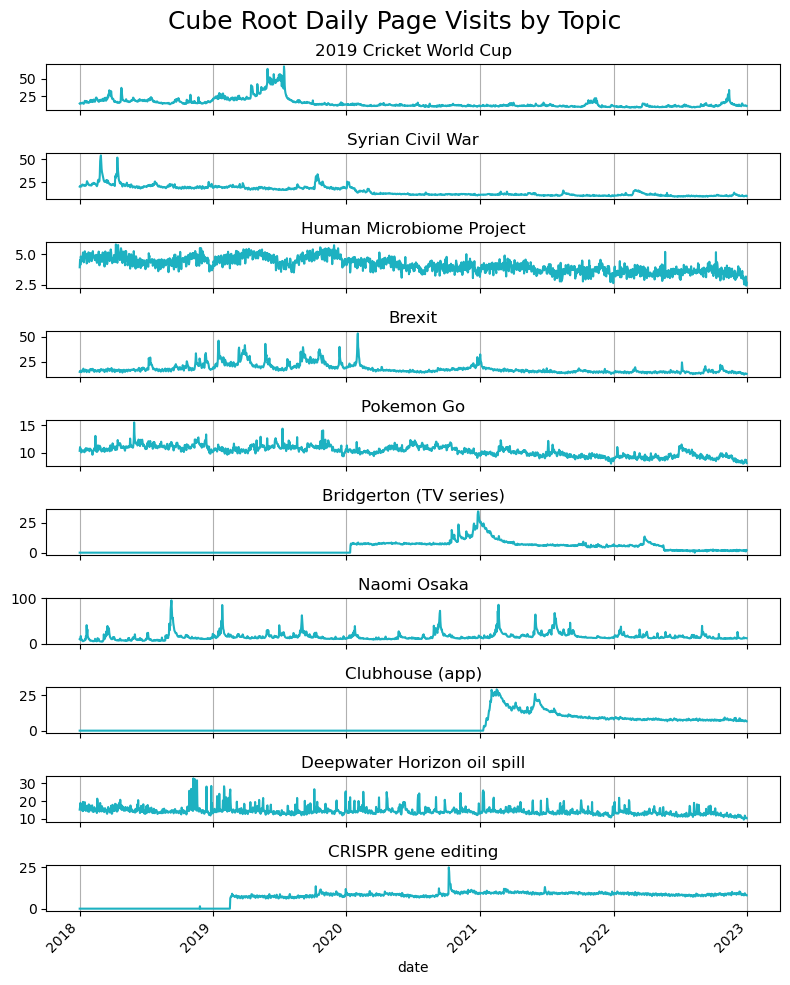

In [78]:
import matplotlib.pyplot as plt

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label=epoch_label,
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="Cube Root Daily Page Visits by Topic"
)  


# Save Main Data File

In [79]:
all_cols = [series_col, epoch_col, value_col] + exog_cols    
data.sort_values(by=[series_col, epoch_col], inplace=True)
data[all_cols].to_csv(outp_fname, index=False)

In [80]:
data[all_cols].head()

,topic,date,cube_root_num_page_visits
43824,2016 Summer Olympics,2018-01-01,14.802
43825,2016 Summer Olympics,2018-01-02,15.503
43826,2016 Summer Olympics,2018-01-03,15.138
43827,2016 Summer Olympics,2018-01-04,15.278
43828,2016 Summer Olympics,2018-01-05,15.408
